In [85]:
import yaml
import os
from pathlib import Path
import pandas as pd
import struct
import random
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# Setup

In [36]:
# experiment setup
PDK = 'sky130'
CLOCK_PERIOD = 10 if PDK == 'sky130' else 2 # ns

# useful paths
energy_char_dpath = Path(os.getcwd()).parent
tests_dpath = energy_char_dpath/f'experiments/tests-{PDK}'
tests_dpath

PosixPath('/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130')

# Generate experiment files

In [67]:
# get pdk clock periods, paths
PDKs = ["sky130"]
clock_periods, test_paths = {}, {}
for pdk in PDKs:
    clock_periods[pdk] = (10 if pdk == "sky130" else 2)
    test_paths[pdk] = energy_char_dpath/f'experiments/tests-{pdk}'

num_inputs = 50
widths = [4, 8, 16, 32, 64]
activity_factors = [0.1, 0.5, 0.9] #[i/10 for i in range(1, 10)]

width_to_max = {}
for i in widths:
    width_to_max[i] = (1 << i) - 1
# tests dict
#   name format: <design>-<test_name>
#       inputs: list, where each item is a tuple of items per line in input.txt
#       defines: for verilog

## Activity Factor Based Input Generation

In [38]:
## get binary string
def getBinary(num, width):
	binary_str = ""
	for i in range(width):
		if (num & (1 << i)):
			binary_str += '1'
		else:
			binary_str += '0'
	return binary_str[::-1]

## find (a, b) s.t. a + b = num
def findNums(num):
	a = random.randint(0, num)
	b = num - a
	return (a, b)


## flip the output (cur_num) given the width and activity factor (prob)
def flip(cur_num, width, prob):
	ret = 0
	for i in range(width):
		on = ((cur_num & (1 << i)) > 0)
		rand_num = random.random()
		## flip bit
		if (rand_num <= prob):
			ret += ((not on) * (1 << i))
		else:
			ret += (on * (1 << i))
	return ret

## verify that the integer pairs (nums) generated from a specified width and activity factor are sensible
def output(width, factor, nums):
	print(f'Width: {width}, Activity Factor: {factor}')
	prev = ""
	for (a, b) in nums:
		print((a, b))
		binary_str = getBinary(a + b, width)
		print(f'New Binary String: {binary_str}')
		if (prev):
			pc = sum([0 if binary_str[i] == prev[i] else 1 for i in range(width)]) / width
			print(f'Percent change: {pc}')
		prev = binary_str


def getInputs(width, activity_factor, num_iter):
	nums = [(0, 0)]
	for i in range(num_iter - 1):
		new_num = flip(sum(nums[-1]), width, activity_factor)
		nums.append(findNums(new_num))
	#output(width, activity_factor, nums) #<-- USE THIS TO VERIFY THAT INPUT PAIRS ARE LOGICAL
	return nums

## add

In [39]:
add_tests = {}

for width in widths:
    design = f"add{width}"
    max_num = width_to_max[width]
    max_in0 = int(max_num/2)
    max_in1 = max_num - max_in0

    original_tests = {
        f'{design}-zero': {
            'inputs': [(0,0) for i in range(num_inputs)],
            'defines': dict(WIDTH=width),
        },
        f'{design}-max_input_switching': {
            # input operands alternate between 0 and all 1's
            'inputs': [((0, 0) if i % 2 else (max_num, max_num)) for i in range(num_inputs)],
            'defines': dict(WIDTH=width),
        },
        f'{design}-max_output_switching': {
            # output operands alternate between 0 and all 1's (so set inputs accordingly)
            'inputs': [((0, 0) if i % 2 else (max_in0, max_in1)) for i in range(num_inputs)],
            'defines': dict(WIDTH=width),
        }
    }
    
    activity_factor_tests = {}
    for factor in activity_factors:
        activity_factor_tests[f'{design}-activity-factor={factor}'] = {
            'inputs': getInputs(width, factor, num_inputs),
            'defines': dict(WIDTH=width),
        }
        
    add_tests.update(original_tests)
    add_tests.update(activity_factor_tests)

## per width, we add len(activity_factors) tests and then another three from Nayiri's original tests
## assert(len(add_tests) == ((len(activity_factors) * len(widths)) + (len(widths) * 3)))

for t in add_tests:
    add_tests[t]['design'] = t.split('-')[0]
    add_tests[t]['inst'] = '/add/adder0'
    add_tests[t]['clock'] = 'clock'
    add_tests[t]['vsrcs'] = ['src/add.v']
    add_tests[t]['vsrcs_tb'] = ['src/add_tb.v']
    add_tests[t]['top_module'] = 'add'
    add_tests[t]['tb_name'] = 'add_tb'
    add_tests[t]['tb_dut'] = 'add_dut'
    add_tests[t]['input_ports'] = ['in0','in1']
    add_tests[t]['output_ports'] = ['out']


## all

Combine all test dicts

In [40]:
tests_dict = add_tests

### Input files

In [41]:
# create dirs
for test_name, test_info in tests_dict.items():
    # experiment directory - will contain all input/output files
    root = tests_dpath/test_name
    root.mkdir(exist_ok=True,parents=True)
    test_info['defines']['TESTROOT'] = root
    test_info['root'] = root
    # hammer build directory
    test_info['obj_dpath'] = energy_char_dpath/f"build-{PDK}-cm/{test_info['design']}"

# convert data operands to binary format to dump to input.txt (gets more complicated for floats)
def val2binary(val,input_format='') -> str:
    if type(val) == str: return val
    elif type(val) == int: return '{0:b}'.format(val)
    elif type(val) == float:
        pack_format = '!e'
        if input_format == 'float32':       pack_format = '!f'
        elif input_format == 'float64':     pack_format = '!d'
        return ''.join('{:0>8b}'.format(c) for c in struct.pack(pack_format, val))
    else: assert(False), f"Invalid dtype, {type(val)}"


# write out input.txt
for test_name, test_info in tests_dict.items():
    input_format = test_info['input_format'] if 'input_format' in test_info else '' # only used for floating point
    with (test_info['root']/'input.txt').open('w') as f:
        for operands in test_info['inputs']:
            f.write(" ".join([val2binary(operand,input_format) for operand in operands]) + '\n')


### Hammer Config

In [42]:
def write_cfg(td):
  defines_str = '\n'.join( [ f"  - {key}={val}" for key,val in td['defines'].items() ] )
  clock_period = 10 if PDK == 'sky130' else 2
  delays = [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: input}}""" for i in td['input_ports']]
  delays += [f"""{{name: {i}, clock: {td['clock']}, delay: "1", direction: output}}""" for i in td['output_ports']]
  delays = ',\n  '.join(delays)
  cfg = f"""\
vlsi.core.build_system: make
vlsi.inputs.power_spec_type: cpf
vlsi.inputs.power_spec_mode: auto

design.defines: &DEFINES
  - CLOCK_PERIOD={clock_period}
{defines_str}

vlsi.inputs.clocks: [{{name: "clock", period: "{clock_period}ns", uncertainty: "100ps"}}]

vlsi.inputs.delays: [
  {delays}
]

synthesis.inputs:
  top_module: {td['top_module']}
  input_files: {td['vsrcs']}
  defines: *DEFINES

sim.inputs:
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  options: ["-timescale=1ns/10ps", "-sverilog"]
  options_meta: append
  defines: *DEFINES
  defines_meta: append
  level: rtl
  input_files: {td['vsrcs'] + td['vsrcs_tb']}

vlsi.core.power_tool: hammer.power.joules
power.inputs:
  level: rtl
  top_module: {td['top_module']}
  tb_name: {td['tb_name']}
  tb_dut: {td['tb_dut']}
  defines: *DEFINES
  input_files: {td['vsrcs']}
  report_configs:
    - waveform_path: {td['root']}/output.fsdb
      report_stem: {td['root']}/power
      toggle_signal: {td['clock']}
      num_toggles: 1
      levels: all
      output_formats:
      - report
      - plot_profile
"""
  with (td['root']/'config.yml').open('w') as f:
    f.write(cfg)

for t in tests_dict:
  write_cfg(tests_dict[t])

## Run experiments

In [43]:
def runCmd(cmd):
    print(f'Executing commmand: {cmd}')
    subprocess.run(f'cd ../ && {cmd}', shell=True)

def runFlow():
    overwrite = False
    # generate custom make str for each test
    make = f""
    make_extra = f"""pdk={PDK}"""

    if PDK == 'intech22': make_extra += f" PDK_CONF=experiments/intech22.yml"
    for t,td in tests_dict.items():
        cfg = str(td['root']/'config.yml')
        td['make'] = f"design={td['design']} {make_extra} DESIGN_CONF={cfg}"

    # build
    build_dpaths = {td['obj_dpath']: t for t,td in tests_dict.items()} # run build once per build dir (not once per test)
    for bd,t in build_dpaths.items():
        if overwrite or not bd.exists():
            runCmd(f"make build {tests_dict[t]['make']} -B")

    # syn
    for bd,t in build_dpaths.items():
        if overwrite or not (bd/"syn-rundir/reports").exists():
            runCmd(f"make syn {tests_dict[t]['make']}")

    # sim-rtl
    for t in tests_dict:
        fp = tests_dict[t]['root']/'output.fsdb'
        if overwrite or not fp.exists():
            runCmd(f"make redo-sim-rtl {tests_dict[t]['make']}")

    # power-rtl
    for t in tests_dict:
        if overwrite or not (tests_dict[t]['root']/'power.power.rpt').exists():
            # re-use pre_report_power database if it's already generated (i.e. skip synthesis)
            make_target = "redo-power-rtl args='--only_step report_power'" \
                if (tests_dict[t]['obj_dpath']/'power-rtl-rundir/pre_report_power').exists() else 'power-rtl'
            runCmd(f"make {make_target} {tests_dict[t]['make']}")


runFlow() ## first pass
runFlow() ## second pass for redo-power-rtl runs

Executing commmand: make redo-sim-rtl design=add4 pdk=sky130 DESIGN_CONF=/bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add4-zero/config.yml
/bwrcq/scratch/shreyas_thumathy/miniforge3/bin/hammer-vlsi -e /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/configs-env/bwrc-env.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/configs-pdk/sky130.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/configs-tool/cm.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/tests-sky130/add4-activity-factor=0.5/config.yml -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/build-sky130-cm/add4/sram_generator-output.json  -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/../configs-pdk/sky130.yml  -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/../configs-tool/cm.yml  -p /bwrcq/scratch/shreyas_thumathy/feb25/hammer/e2e/hammer-energy-char/experiments/te

## Parse results

In [86]:
def parse_hier_power_rpt(fpath,inst) -> list:
    with fpath.open('r') as f: lines = f.readlines()
    for l in lines:
        words = l.split()
        if l.startswith('Power Unit'):
            assert(words[-1] == 'mW'), f"Wrong power unit in report, {l}"
        if inst == words[-1]:
            return [float(p) for p in words[2:6]]
    return []

def get_duration(fpath) -> float:
    with fpath.open('r') as f: lines = f.readlines()
    time_power = [l.split() for l in lines]
    time_power = [tp for tp in time_power if len(tp) == 2]
    start = float(time_power[0][0])
    end   = float(time_power[-1][0])
    return end-start

time = []
power = list([])
results_for_plots = {}
for w in widths:
    results_for_plots[f"add{w}"] = [[], []]

for t in tests_dict:
    fpath = tests_dict[t]['root']/'power.hier.power.rpt'
    cur_power = parse_hier_power_rpt(fpath,tests_dict[t]['inst'])
    power.append(cur_power)
    fpath = tests_dict[t]['root']/'power.profile.png.data'
    design_name, cur_factor = "", 0

    for w in widths:
        if f"add{w}" in str(tests_dict[t]['root']):
            design_name = f"add{w}"
#    print(design_name)

    for factor in activity_factors:
        if f"activity-factor={factor}" in str(tests_dict[t]['root']):
            cur_factor = factor

    if "max_output_switching" in str(tests_dict[t]['root']):
        cur_factor = 1
    
    cur_time = get_duration(fpath)
    if (cur_factor != 0):
        results_for_plots[design_name][0].append(cur_factor)
        results_for_plots[design_name][1].append(np.array(cur_power) * cur_time / num_inputs)
    time.append(cur_time)

time = pd.Series(time,   #  ns
                    #  columns=['Duration'],
                     index=tests_dict.keys()) # type: ignore

power = pd.DataFrame(power,   #  mW
                     columns=['Leakage','Internal','Switching','Total'],
                     index=tests_dict.keys()) # type: ignore



print(results_for_plots)
energy = power.mul(time,axis=0) / num_inputs # mW * ns = pJ
energy.columns = [c+' (pJ)' for c in energy.columns]
energy.insert(0,'time',time)
energy.insert(0,'test',[i.split('-')[1] for i in energy.index])
energy.insert(0,'design',[i.split('-')[0] for i in energy.index])

#print(results_for_plots)
energy.to_hdf(PDK+'.h5',key='df',mode='w')
energy


{'add4': [[1, 0.1, 0.5, 0.9], [array([6.9516280e-07, 2.6102743e-01, 6.5081976e+00, 6.7692220e+00]), array([7.2052390e-07, 6.2682923e-02, 7.2379024e-01, 7.8647387e-01]), array([7.2375590e-07, 1.5925377e-01, 3.2552199e+00, 3.4144666e+00]), array([7.1310040e-07, 2.3998307e-01, 5.8065203e+00, 6.0465064e+00])]], 'add8': [[1, 0.1, 0.5, 0.9], [array([1.4476128e-06, 5.4556867e-01, 1.3009406e+01, 1.3555008e+01]), array([1.5163433e-06, 2.2573298e-01, 1.2026676e+00, 1.4284026e+00]), array([1.5041930e-06, 3.8725622e-01, 6.5679290e+00, 6.9551933e+00]), array([1.5019609e-06, 5.6599996e-01, 1.1687114e+01, 1.2253118e+01])]], 'add16': [[1, 0.1, 0.5, 0.9], [array([3.1223342e-06, 1.1737816e+00, 2.6105167e+01, 2.7278888e+01]), array([3.2433625e-06, 3.9937925e-01, 2.9755105e+00, 3.3748948e+00]), array([3.2788438e-06, 8.0387415e-01, 1.3309073e+01, 1.4112932e+01]), array([3.2637039e-06, 1.1777408e+00, 2.3536737e+01, 2.4714498e+01])]], 'add32': [[1, 0.1, 0.5, 0.9], [array([7.2781711e-06, 2.2882358e+00, 5.2091

,design,test,time,Leakage (pJ),Internal (pJ),Switching (pJ),Total (pJ)
add4-zero,add4,zero,505.0,7.289877e-07,0.000000,0.000000,7.289877e-07
add4-max_input_switching,add4,max_input_switching,505.0,7.386938e-07,0.257707,4.944405,5.202106e+00
add4-max_output_switching,add4,max_output_switching,505.0,6.951628e-07,0.261027,6.508198,6.769222e+00
add4-activity-factor=0.1,add4,activity,505.0,7.205239e-07,0.062683,0.723790,7.864739e-01
add4-activity-factor=0.5,add4,activity,505.0,7.237559e-07,0.159254,3.255220,3.414467e+00
add4-activity-factor=0.9,add4,activity,505.0,7.131004e-07,0.239983,5.806520,6.046506e+00
add8-zero,add8,zero,505.0,1.597295e-06,0.000000,0.000000,1.597295e-06
add8-max_input_switching,add8,max_input_switching,505.0,1.519818e-06,0.616669,11.503799,1.212051e+01
add8-max_output_switching,add8,max_output_switching,505.0,1.447613e-06,0.545569,13.009406,1.355501e+01
add8-activity-factor=0.1,add8,activity,505.0,1.516343e-06,0.225733,1.202668,1.428403e+00


## Generate Plot

Design: add4, Factors: [1, 0.1, 0.5, 0.9], Energy: [np.float64(6.5081976), np.float64(0.72379024), np.float64(3.2552199), np.float64(5.806520300000001)]
Design: add8, Factors: [1, 0.1, 0.5, 0.9], Energy: [np.float64(13.009405999999998), np.float64(1.2026676), np.float64(6.567929), np.float64(11.687114000000001)]
Design: add16, Factors: [1, 0.1, 0.5, 0.9], Energy: [np.float64(26.105167), np.float64(2.9755105000000004), np.float64(13.309073000000001), np.float64(23.536737)]
Design: add32, Factors: [1, 0.1, 0.5, 0.9], Energy: [np.float64(52.091659), np.float64(6.504632300000001), np.float64(25.936093), np.float64(47.06701)]
Design: add64, Factors: [1, 0.1, 0.5, 0.9], Energy: [np.float64(104.93294), np.float64(12.595508), np.float64(53.973188), np.float64(93.380358)]


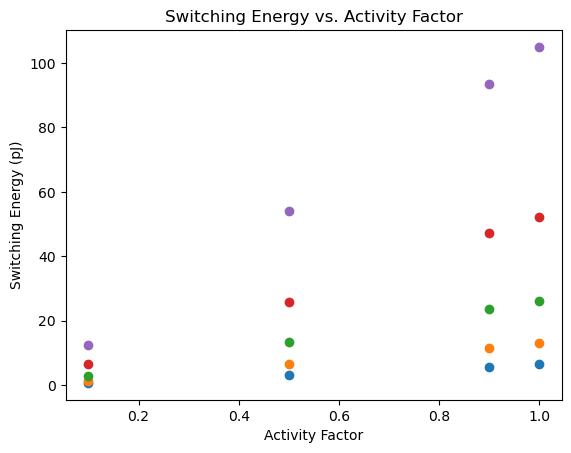

In [ ]:



plt.title("Switching Energy vs. Activity Factor")
plt.xlabel("Activity Factor")
plt.ylabel("Switching Energy (pJ)")
for design in results_for_plots.keys():
    ## assign (color, shape) to design
    x_vals, y_vals = [], []
    for (x, y) in zip(results_for_plots[design][0], results_for_plots[design][1]):
        x_vals.append(x)
        y_vals.append(y[2]) ## 2nd index contains switching power
    print(f"Design: {design}, Factors: {x_vals}, Energy: {y_vals}")
    plt.scatter(x_vals, y_vals)
plt.show()

## Notes
What do we want to test?

Inputs:
* 0 -> 0
* 0 -> 11...11
* different activity factors of adds

Designs:
* minimum critical path - can we force the synthesis tool to use faster gates

Flow:
* sim-rtl > power-rtl